In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft, fft2, ifft2, fftshift, ifftshift, fftn, ifftn

import pickle
import waveorder as wo
import time

%matplotlib inline
plt.style.use(['dark_background']) # Plotting option for dark background


### Experiment parameters

In [2]:
N           = 300                 # number of pixel in y dimension
M           = 300                 # number of pixel in x dimension
L           = 100                 # number of layers in z dimension
n_media     = 1.33                # refractive index in the media
mag         = 63                  # magnification
ps          = 6.5/mag             # effective pixel size
psz         = 0.125                # axial pixel size
lambda_illu = 0.532               # wavelength
NA_obj      = 1.2                 # objective NA
NA_illu     = 0.9                 # illumination NA
use_gpu     = True
gpu_id      = 2

### Sample creation

In [3]:
radius = 3
blur_size = 2*ps
sphere = wo.gen_sphere_target((N,M,L), ps, psz, radius, blur_size)
wo.image_stack_viewer(np.transpose(sphere,(2,0,1)))

interactive(children=(IntSlider(value=0, description='stack_idx', max=99), Output()), _dom_classes=('widget-in…

<function waveorder.visual.image_stack_viewer.<locals>.interact_plot_3D(stack_idx)>

In [4]:
## Physical value assignment

n_sample = 1.33+0.02 

RI_map = np.zeros_like(sphere)
RI_map[sphere > 0] = sphere[sphere > 0]*(n_sample-n_media)
RI_map += n_media
t_obj = np.exp(1j*2*np.pi*psz*(RI_map-n_media)/lambda_illu)


In [5]:
wo.image_stack_viewer(np.transpose(np.angle(t_obj),(2,0,1)))

interactive(children=(IntSlider(value=0, description='stack_idx', max=99), Output()), _dom_classes=('widget-in…

<function waveorder.visual.image_stack_viewer.<locals>.interact_plot_3D(stack_idx)>

### Setup acquisition

In [26]:
# Discrete source assignment

xx, yy, fxx, fyy = wo.gen_coordinate((N, M), ps)
Pupil_obj = wo.gen_Pupil(fxx, fyy, NA_obj/n_media, lambda_illu/n_media)
Source_support = wo.gen_Pupil(fxx, fyy, NA_obj/n_media, lambda_illu/n_media)

NAx_coord = lambda_illu/n_media*fxx
NAy_coord = lambda_illu/n_media*fyy


Source = np.zeros((N, M))

Source_BF = wo.gen_Pupil(fxx, fyy, NA_illu/n_media, lambda_illu/n_media)
Source = wo.Source_subsample(Source_BF, NAx_coord, NAy_coord, subsampled_NA = 0.1/n_media)


273.0

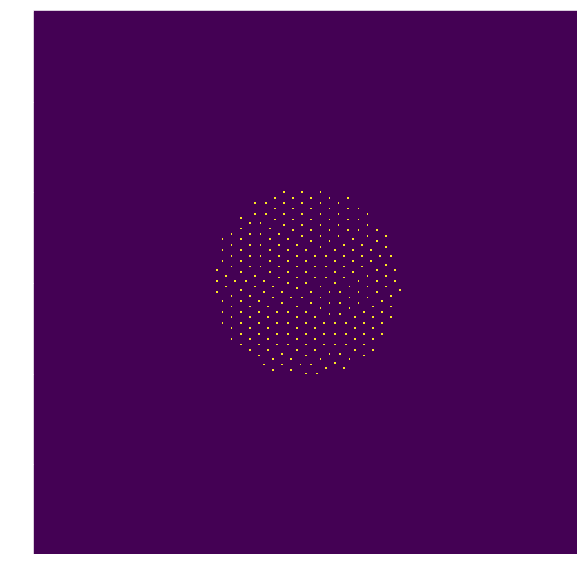

In [27]:
plt.figure(figsize=(10,10))
plt.imshow(fftshift(Source))
np.sum(Source)

In [28]:
z_defocus = (np.r_[:L]-L//2)*psz
chi = 0.1*2*np.pi
setup = wo.waveorder_microscopy((N,M), lambda_illu, ps, NA_obj, NA_illu, z_defocus, chi, \
                                n_media = n_media, phase_deconv='3D', illu_mode = 'Arbitrary', Source=Source)

simulator = wo.waveorder_microscopy_simulator((N,M), lambda_illu, ps, NA_obj, NA_illu, z_defocus, chi, \
                                n_media = n_media, illu_mode = 'Arbitrary', Source=Source,use_gpu=use_gpu, gpu_id=gpu_id)


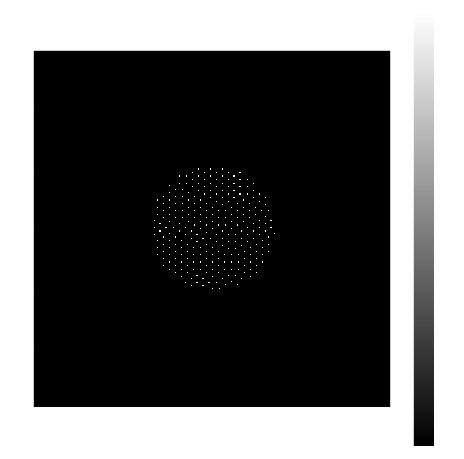

In [29]:
plt.figure(figsize=(8,8))
plt.imshow(fftshift(setup.Source), cmap='gray')
plt.colorbar()

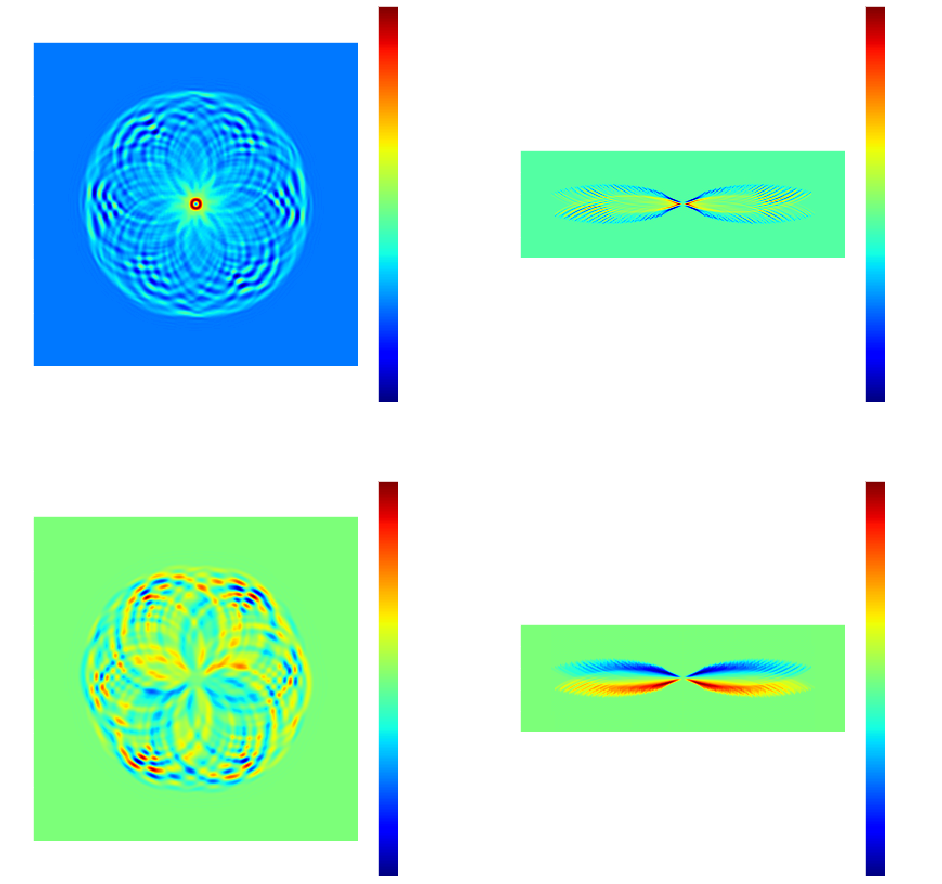

In [30]:
H_re_vis = fftshift(setup.H_re)

wo.plot_multicolumn([np.real(H_re_vis)[:,:,L//2], np.transpose(np.real(H_re_vis)[N//2,:,:]), \
                     np.imag(H_re_vis)[:,:,L//2], np.transpose(np.imag(H_re_vis)[N//2,:,:])], \
                    num_col=2, size=8, set_title=True, \
                    titles=['$xy$-slice of Re{$H_{re}$} at $u_z=0$', '$xz$-slice of Re{$H_{re}$} at $u_y=0$', \
                            '$xy$-slice of Im{$H_{re}$} at $u_z=0$', '$xz$-slice of Im{$H_{re}$} at $u_y=0$'], colormap='jet')

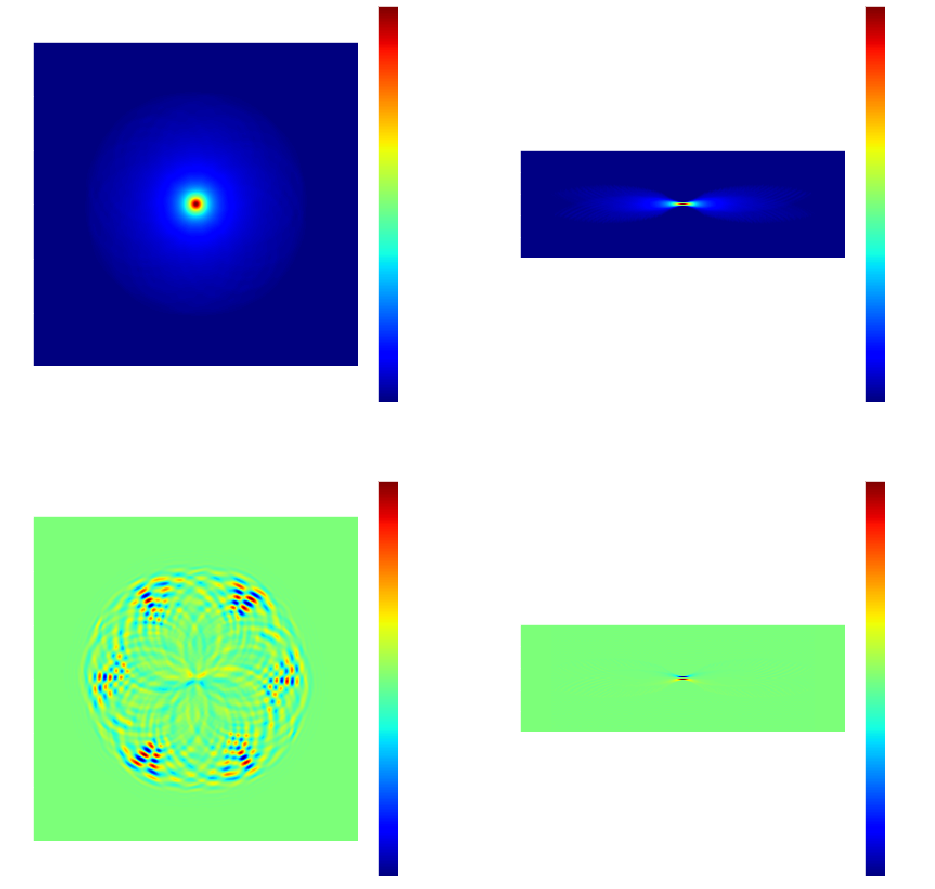

In [31]:
H_im_vis = fftshift(setup.H_im)

wo.plot_multicolumn([np.real(H_im_vis)[:,:,L//2], np.transpose(np.real(H_im_vis)[N//2,:,:]), \
                     np.imag(H_im_vis)[:,:,L//2], np.transpose(np.imag(H_im_vis)[N//2,:,:])], \
                    num_col=2, size=8, set_title=True, \
                    titles=['$xy$-slice of Re{$H_{im}$} at $u_z=0$', '$xz$-slice of Re{$H_{im}$} at $u_y=0$', \
                            '$xy$-slice of Im{$H_{im}$} at $u_z=0$', '$xz$-slice of Im{$H_{im}$} at $u_y=0$'], colormap='jet')

In [32]:
I_meas = simulator.simulate_3D_scalar_measurements(t_obj)

Number of point sources considered (100 / 273) in pattern (1 / 1), elapsed time: 50.77
Number of point sources considered (200 / 273) in pattern (1 / 1), elapsed time: 101.62
Number of point sources considered (273 / 273) in pattern (1 / 1), elapsed time: 138.80


In [33]:
wo.image_stack_viewer(np.transpose(np.abs(I_meas),(0,1,2)))

interactive(children=(IntSlider(value=0, description='stack_idx', max=299), Output()), _dom_classes=('widget-i…

<function waveorder.visual.image_stack_viewer.<locals>.interact_plot_3D(stack_idx)>

In [34]:
I_meas_SEAGLE = simulator.simulate_3D_scalar_measurements_SEAGLE(RI_map, itr_max = 100, tolerance=1e-4, verbose=False)

Number of point sources considered (1 / 273) in pattern (1 / 1), elapsed time: 6.60
Number of point sources considered (2 / 273) in pattern (1 / 1), elapsed time: 13.66
Number of point sources considered (3 / 273) in pattern (1 / 1), elapsed time: 20.75
Number of point sources considered (4 / 273) in pattern (1 / 1), elapsed time: 27.88
Number of point sources considered (5 / 273) in pattern (1 / 1), elapsed time: 35.55
Number of point sources considered (6 / 273) in pattern (1 / 1), elapsed time: 43.82
Number of point sources considered (7 / 273) in pattern (1 / 1), elapsed time: 52.71
Number of point sources considered (8 / 273) in pattern (1 / 1), elapsed time: 61.60
Number of point sources considered (9 / 273) in pattern (1 / 1), elapsed time: 69.30
Number of point sources considered (10 / 273) in pattern (1 / 1), elapsed time: 76.40
Number of point sources considered (11 / 273) in pattern (1 / 1), elapsed time: 83.54
Number of point sources considered (12 / 273) in pattern (1 / 1)

In [36]:
wo.parallel_4D_viewer(np.transpose(np.stack([I_meas_SEAGLE,I_meas]),(2,0,1,3)))

interactive(children=(IntSlider(value=0, description='stack_idx', max=299), Output()), _dom_classes=('widget-i…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

In [38]:
# Save simulations

f = open('simulation_data_PODT.pckl', 'wb')
pickle.dump((I_meas, lambda_illu, n_media, ps, psz, NA_obj, NA_illu), f)
f.close()

In [37]:
# Save simulations

f = open('simulation_data_PODT_SEAGLE.pckl', 'wb')
pickle.dump((I_meas_SEAGLE, lambda_illu, n_media, ps, psz, NA_obj, NA_illu), f)
f.close()